In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, Bounds
from sklearn.model_selection import train_test_split

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## Custom code
Need to create:
- `forward` method that runs training data through the network and accepts parameters as inputs
- MSE loss function that accepts parameters as args and is parametrized by training data
- select optimizer (they use full-batch (!?) GD)

In [45]:
# Optimizer code

def geval(func, x, idx=None):
    # numerically computes the gradient of a function by forward differences
    
    n = x.shape[0]
    fx = func(x)
    eps = 1e-8  # could be made better
    xperturb = x

    g = np.zeros((n, 1))
    for i in range(n):
        xperturb[i] = xperturb[i] + eps
        g[i] = (func(xperturb)-fx)/eps
        xperturb[i] = x[i]
    
    return g[idx] if idx is not None else g


def GD(x0, gfun, alpha=1, maxiter=int(1e6), tol=1e-7, cutoff=False):
    x = x0
    
    gnorms = []
    for iter in range(maxiter):
        xp = x
        gp = gfun(xp)
        x = xp - alpha*gp
        
        gnorms.append(np.linalg.norm(gp))
        if iter > 0 and np.linalg.norm(gnorms[i]) < tol: break
        if cutoff and iter > 1000: break
    if iter == maxiter: print('max iterations reached')
    return x, np.array(gnorms)

def SGD(x0, gfun, schedule='recip', maxiter=250, lr=0.8, r=0.95**(-1), M=None):
    # Stochastic gradient descent function with batch size 1
    # Input: x0   = initial guess
    #        gfun = gradient of function accepting index to report at

    x = x0
    n = train_pts.shape[0]
    iterpts = iterrange = range(maxiter)

    # Create stepped array
    if M is not None: iterpts = [iter // M for iter in iterrange]

    # Set stepsize reduction strategy
    if schedule == 'recip':
        alpha = [lr/(iter + 1) for iter in iterpts]
    elif schedule == 'time':
        alpha = np.zeros((maxiter,)); alpha[0] = lr
        for iter in range(1, maxiter): alpha[iter] = alpha[iter-1]/(1 + r*iter)
    elif schedule == 'exp':
        alpha = [lr*np.exp(-r*iter) for iter in iterpts]
    elif schedule == 'cons':
        alpha = [lr for iter in iterrange]
    else: raise RuntimeError('unimplemented scheduler')

    gnorms = []
    for iter in iterrange:
        xp = x
        idx = np.random.randint(0, n)  # generate random batch
        gp = gfun(xp, I=idx)
        x = xp - alpha[iter]*gp

        error = np.linalg.norm(x - m)
        gnorm = np.linalg.norm(gp)
        gnorms.append(gnorm)
    
    return x, np.array(gnorms)

In [3]:
def relu(x):
    return np.maximum(np.zeros(x.shape), x)

def encoder(X, contiguity, n_layers, n_nodes, params):
    # X          = n x p feature matrix of data at each location
    # contiguity = binary contiguity matrix showing first order neighbors
    # n_layers   = number of layers
    # params     = numpy array of all the parameters
    N, p = X.shape

    # Fetch parameters
    W_list = [params[:p*n_nodes].reshape(n_nodes, p)]
    W_list.extend([params[i:i + n_nodes**2].reshape(n_nodes, n_nodes) for i in range(n_layers)])

    prev = X
    zl = np.zeros((N, n_nodes))
    for l in range(n_layers + 1):     # for each layer
        for i in range(N):   # for each location
            rows = prev[contiguity[i, :], :]  # get the rows of all neighbors of current location (convolution)
            
            # Compute all products with the parameters
            layerterms = np.zeros((rows.shape[0], n_nodes))
            for j in range(rows.shape[0]):
                layerterms[j, :] = np.dot(W_list[l], rows[j, :].T)
            
            zl[i, :] = relu(layerterms.sum(0)/layerterms.sum(0).max())  # embed
        prev = zl
    
    return zl

def decoder(zL, R):
    # zL = n x H matrix of feature embeddings at final layer
    # R  = H x H matrix of parameters that allow us to estimate flows
    flows = zL @ R @ zL.T
    return flows.flatten()

def predict(X, contiguity, n_layers, n_nodes, params):
    N, p = X.shape
    R = params[-n_nodes**2:].reshape(n_nodes, n_nodes)
    return decoder(encoder(X, contiguity, n_layers, n_nodes, params), R)

def loss(X, params, contiguity, true_flows, n_layers, n_nodes, lam):
    N, _ = X.shape
    return ((predict(X, contiguity, n_layers, n_nodes, params) - true_flows)**2).sum()/N + lam*np.linalg.norm(params, 1)

## Load Austria dataset

In [4]:
austria = pd.read_csv('austria.csv', converters={'Oi' : float, 'Dj' : float, 'Dij' : float, 'Data' : float})

raw_origins = austria['Oi'].values
raw_destinations = austria['Dj'].values
raw_distances = austria['Dij'].values
raw_observed = austria['Data'].values

loc_attrs = austria['Oi'].values[::9].reshape(-1, 1)

In [54]:
# Remove self flows -- DON'T RUN THIS CELL
raw_origins = np.delete(origins, np.arange(0, origins.size, 10))
raw_destinations = np.delete(destinations, np.arange(0, destinations.size, 10))
raw_distances = np.delete(distances, np.arange(0, distances.size, 10))
raw_observed = np.delete(observed, np.arange(0, observed.size, 10))

In [5]:
# Log-transform data to (0, 1]
origins = np.log(raw_origins)/np.log(raw_origins.max())
destinations = np.log(raw_destinations)/np.log(raw_destinations.max())
distances = np.log(raw_distances)/np.log(raw_distances.max())
observed = np.log(raw_observed)/np.log(raw_observed.max())
observed[observed == -np.inf] = 0

In [6]:
# Put back into dataframe for later
data = pd.DataFrame(data=np.column_stack((origins, destinations, distances, observed)), columns=['Oi', 'Dj', 'Dij', 'Tij'])
N = len(origins)
M = len(destinations)

In [7]:
# Build contiguity matrix
#                     11, 12, 13, 21, 22, 31, 32, 33, 34
austria_W = np.array([[1,  1,  0,  0,  1,  0,  0,  0,  0],  # 11
                      [1,  1,  1,  0,  1,  1,  0,  0,  0],  # 12
                      [0,  1,  1,  0,  0,  0,  0,  0,  0],  # 13
                      [0,  0,  0,  1,  1,  0,  1,  1,  0],  # 21
                      [1,  1,  0,  1,  1,  1,  1,  0,  0],  # 22
                      [0,  1,  0,  0,  1,  1,  1,  0,  0],  # 31
                      [0,  0,  0,  1,  1,  1,  1,  1,  0],  # 32
                      [0,  0,  0,  1,  0,  0,  1,  1,  1],  # 33
                      [0,  0,  0,  0,  0,  0,  0,  1,  1]], dtype=bool) # 34
(austria_W.transpose() == austria_W).all()  # should be True if it's symmetric

True

## Instantiate and run model

In [57]:
# Constants
p = 1           # number of attributes at each location
n_layers = 1    # number of layers for the network
n_nodes  = 50   # number of nodes in each layer
lam = 0         # regularization

# Set up parameter matrices (all Wl and R)
params0 = np.zeros(((p + (n_layers + 1)*n_nodes)*n_nodes,))
params0[:p*n_nodes] = np.random.random(size=(n_nodes, p)).flatten()
for i in range(n_layers):
    params0[i:i + n_nodes**2] = np.random.random(size=(n_nodes, n_nodes)).flatten()

In [44]:
packed_loss = lambda params : loss(loc_attrs, params, austria_W, observed, n_layers, n_nodes, lam)
params = GD(params0, lambda x : geval(packed_loss, x), alpha=1, maxiter=int(1e6), tol=1e-7)

ValueError: cannot reshape array of size 12625000 into shape (50,50)

In [58]:
%%time

opts = {'maxiter' : 30, 'disp' : True}
res = minimize(lambda params : loss(loc_attrs, params, austria_W, observed, n_layers, n_nodes, lam), params0, jac='cs', options=opts)  # uh oh this takes a while
params = res.x
losses = res.jac
res.nit

Optimization terminated successfully.
         Current function value: 0.389304
         Iterations: 26
         Function evaluations: 181836
         Gradient evaluations: 36
CPU times: user 15min 33s, sys: 1min 7s, total: 16min 41s
Wall time: 8min 28s


26

In [59]:
loss(loc_attrs, params, austria_W, observed, n_layers, n_nodes, lam)

0.38930402282278465

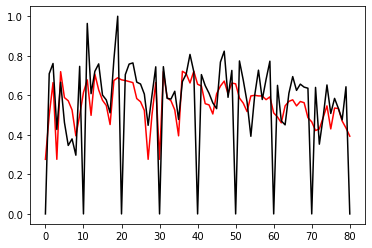

In [61]:
plt.plot(predict(loc_attrs, austria_W, n_layers, n_nodes, params), 'r')
plt.plot(observed, 'k')
plt.show()